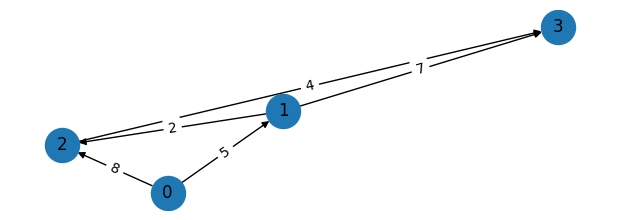

/home/alex/TFG/qiskit_env/lib/python3.12/site-packages/qiskit_ibm_runtime/qiskit_runtime_service.py:857: UserWarning: IBM Quantum Platform is moving, and this version will be sunset on July 1. To get started on the new platform, read the migration guide at https://docs.quantum.ibm.com/migration-guides/classic-iqp-to-cloud-iqp
  warnings.warn(warning_message)


In [16]:
from qiskit import QuantumCircuit, transpile
from qiskit_ibm_runtime import QiskitRuntimeService, Sampler
import matplotlib.pyplot as plt
import numpy as np
import networkx as nx
import itertools
import pandas as pd
from tabulate import tabulate
import time
from typing import List, Tuple

# --- Definición del problema ---
edges = {(0, 1): 5, (0, 2): 8, (1, 2): 2, (1, 3): 7, (2, 3): 4}
num_nodes = 4
linear_coefs = [11, -17.5, -28, -17, 11.5]
quadra_coefs = {
    (0, 1): 13.5, (0, 2): -13.5, (0, 3): -13.5,
    (1, 2): 13.5, (1, 4): -13.5,
    (2, 3): 13.5, (2, 4): -13.5
}
cost_function = "\
5*x_01 + 8*x_02 + 2*x_12 + 7*x_13 + 4*x_23 + \
27*(x_01 + x_02 - 1)**2 + \
27*(x_01 - x_12 - x_13)**2 + \
27*(x_02 + x_12 - x_23)**2"

num_shots=2048

def print_graph(nodes, edges, layout=None):
    import matplotlib.pyplot as plt
    import networkx as nx
    G = nx.DiGraph()
    G.add_nodes_from(nodes)
    for (i, j), w in edges.items():
        G.add_edge(i, j, weight=w)
    if layout is None:
        layout = nx.spring_layout(G)
    plt.figure(figsize=(6, 2))
    nx.draw(G, layout, with_labels=True, node_size=600)
    labels = nx.get_edge_attributes(G, "weight")
    nx.draw_networkx_edge_labels(G, pos=layout, edge_labels=labels)
    plt.show()

def eval_cost_function(bits: str) -> float:
    inv_bits = bits[::-1]
    param = {f"x_{i}{j}": int(inv_bits[n]) for n, (i, j) in enumerate(edges)}
    return eval(cost_function, param)

def generate_qaoa_circuit(theta: List[float]) -> QuantumCircuit:
    n = len(linear_coefs)
    circuit = QuantumCircuit(n)
    layers = len(theta) // 2
    beta, gamma = theta[:layers], theta[layers:]
    for i in range(n):
        circuit.h(i)
    for p in range(layers):
        circuit.barrier()
        for i, coef in enumerate(linear_coefs):
            circuit.rz(coef * 2 * gamma[p], i)
        for (q0, q1), coef in quadra_coefs.items():
            circuit.rzz(coef * 2 * gamma[p], q0, q1)
        circuit.barrier()
        for i in range(n):
            circuit.rx(2 * beta[p], i)
    circuit.measure_all()
    return circuit

def calculate_P_GS_and_TTS(counts: dict, opt_states: List[Tuple[str]], t_sample: float):
    total = sum(counts.values())
    opt = sum(counts.get(s, 0) for s in opt_states)
    p_gs = opt / total if total > 0 else 0
    tts = t_sample * np.log(1 / (1 - 0.99)) / p_gs if p_gs > 0 else float("inf")
    return p_gs, tts

# --- Visualizar grafo ---
print_graph(range(num_nodes), edges)

# --- Configuración IBM Quantum ---
token = "TOKEN"
service = QiskitRuntimeService(channel="ibm_quantum", token=token)
backend = service.backend("ibm_brisbane")

# --- Parámetros QAOA (previamente optimizados) ---
theta_opt = [1.0, 0.8, 0.6, 1.2, 0.9, 0.7]

# --- Preparar circuito QAOA ---
qc = generate_qaoa_circuit(theta_opt)
transpiled = transpile(qc, backend, layout_method='sabre', optimization_level=3)


# --- Ejecutar en el hardware real ---
sampler = Sampler(mode=backend)
job = sampler.run([transpiled], shots=num_shots)
result = job.result()


In [17]:
import numpy as np
import pandas as pd
from tabulate import tabulate
from qiskit.visualization import plot_histogram
from math import log

# --- Parámetros ---
optimal_bitstring = "10101"
opt_states = [optimal_bitstring]
opt_value = eval_cost_function(optimal_bitstring)
num_shots = 1024

# --- Extraer tiempo de ejecución desde metadatos ---
execution_start = result.metadata['execution']['execution_spans'][0].start
execution_end = result.metadata['execution']['execution_spans'][0].stop
execution_time = (execution_end - execution_start).total_seconds() * 1000  # ms
t_sample = execution_time / num_shots

# --- Obtener los counts ---
counts = result[0].data.meas.get_counts()  # ← Esto es un diccionario tipo {'10101': 300, ...}

# --- Mostrar histograma ---
plot_histogram(counts)

# --- Función para calcular P_GS y TTS ---
def calculate_P_GS_and_TTS(counts, opt_states, t_sample):
    success_counts = sum(counts.get(state, 0) for state in opt_states)
    p_gs = success_counts / num_shots

    if p_gs == 0:
        tts = float("inf")
    else:
        tts = t_sample * log(1 / (1 - 0.99)) / p_gs

    return p_gs, tts

# --- Calcular métricas ---
p_gs, tts = calculate_P_GS_and_TTS(counts, opt_states, t_sample)

# --- Mostrar resultados ---
print("P_GS:", p_gs)
print("t_sample:", t_sample, "ms")
print("TTS:", tts, "ms")

# --- Tabla con pandas ---
df = pd.DataFrame({
    "Instance": ["(4, 4, 0)"],
    "Opt": [opt_value],
    "P_GS": [p_gs],
    "t_sample (ms)": [t_sample],
    "TTS (ms)": [tts]
})
display(df)


P_GS: 0.044921875
t_sample: 1.4392314453125 ms
TTS: 147.54294522857015 ms


,Instance,Opt,P_GS,t_sample (ms),TTS (ms)
0,"(4, 4, 0)",11,0.044922,1.439231,147.542945


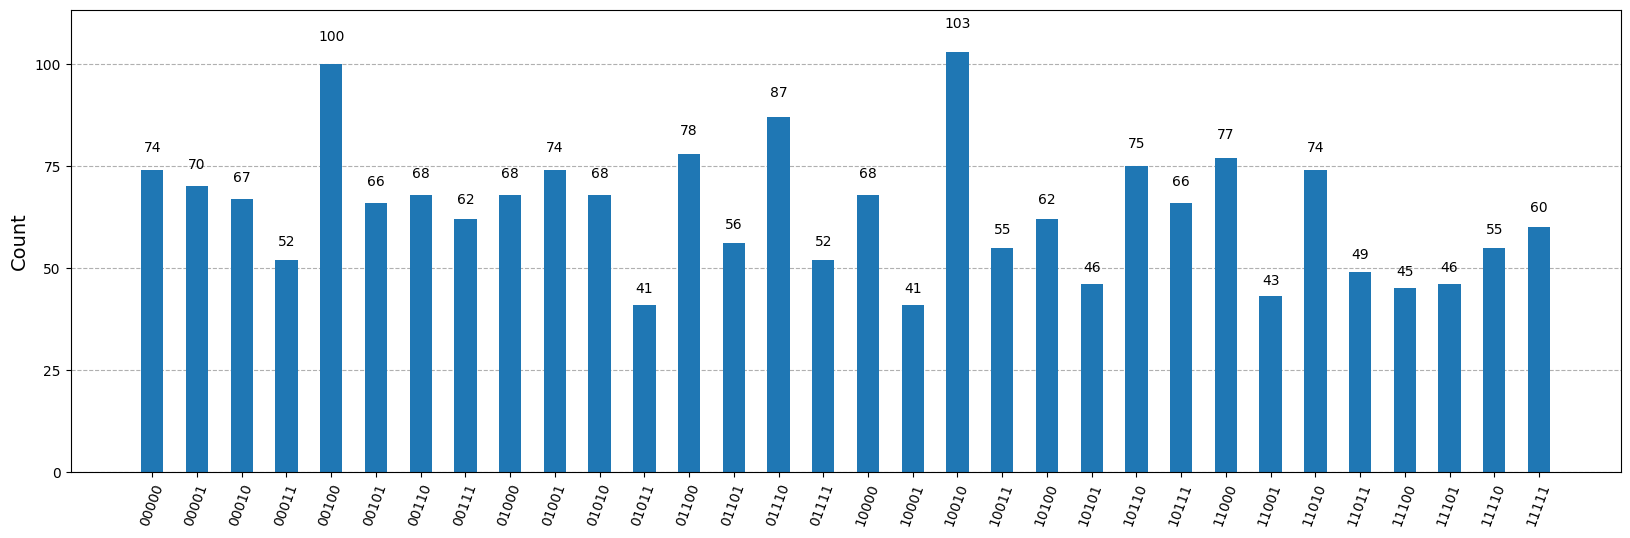

In [18]:
from qiskit.visualization import plot_histogram
from IPython.display import display

# Ajusta el tamaño: (ancho, alto) en pulgadas
display(plot_histogram(counts, figsize=(20, 6)))

In [19]:

# --- Parámetros óptimos ---
logical_opt_bitstring = "10101"
hardware_opt_bitstring = logical_opt_bitstring[::-1]  # Invertido para comparar con counts
opt_value = eval_cost_function(hardware_opt_bitstring)
opt_states = [hardware_opt_bitstring]

# --- Calcular métricas ---
p_gs, tts = calculate_P_GS_and_TTS(counts, opt_states, t_sample)

# --- Mostrar histograma ---
from qiskit.visualization import plot_histogram
plot_histogram(counts)

# --- Mostrar resultados principales ---
sorted_counts = sorted(counts.items(), key=lambda x: x[1], reverse=True)
print("\nTop 10 estados medidos:")
for bitstring, count in sorted_counts[:10]:
    logical_bits = bitstring[::-1]
    cost = eval_cost_function(bitstring)
    print(f"Medido: {bitstring} | Lógico: {logical_bits} | Coste: {cost:.2f} | Frecuencia: {count}")

# --- Tabla resumen ---
df = pd.DataFrame({
    "Instance": ["(4, 4, 0)"],
    "Opt": [opt_value],
    "P_GS": [p_gs],
    "t_sample (ms)": [t_sample],
    "TTS (ms)": [tts]
})
print("\nResumen:")
print(df.to_markdown(index=False))



Top 10 estados medidos:
Medido: 10010 | Lógico: 01001 | Coste: 12.00 | Frecuencia: 103
Medido: 00100 | Lógico: 00100 | Coste: 83.00 | Frecuencia: 100
Medido: 01110 | Lógico: 01110 | Coste: 233.00 | Frecuencia: 87
Medido: 01100 | Lógico: 00110 | Coste: 171.00 | Frecuencia: 78
Medido: 11000 | Lógico: 00011 | Coste: 92.00 | Frecuencia: 77
Medido: 10110 | Lógico: 01101 | Coste: 68.00 | Frecuencia: 75
Medido: 01001 | Lógico: 10010 | Coste: 12.00 | Frecuencia: 74
Medido: 11010 | Lógico: 01011 | Coste: 46.00 | Frecuencia: 74
Medido: 00000 | Lógico: 00000 | Coste: 27.00 | Frecuencia: 74
Medido: 00001 | Lógico: 10000 | Coste: 32.00 | Frecuencia: 70

Resumen:
| Instance   |   Opt |      P_GS |   t_sample (ms) |   TTS (ms) |
|:-----------|------:|----------:|----------------:|-----------:|
| (4, 4, 0)  |    11 | 0.0449219 |         1.43923 |    147.543 |
